**Нейронная сеть для классификации кошек и собак**


# Загрузка и подготовка датасета

In [1]:
#Необходимые библиотеки

import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
from PIL import Image, ImageFont


%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow 1.x selected.


Загрузим необходиммые данные

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

68608000/68606236 [==============================] - 1s 0us/step


In [3]:
! ls /root/.keras/datasets/cats_and_dogs_filtered

train  validation  vectorize.py


In [4]:
base_dir = Path(zip_dir).parent / "cats_and_dogs_filtered"
train_dir = base_dir / 'train'
validation_dir = base_dir / 'validation'

train_cats_dir = train_dir / 'cats'
train_dogs_dir = train_dir / 'dogs'
validation_cats_dir = validation_dir / 'cats'
validation_dogs_dir = validation_dir / 'dogs'

In [5]:
num_cats_tr = len(list(train_cats_dir.glob("*")))
num_dogs_tr = len(list(train_dogs_dir.glob("*")))

num_cats_val = len(list(validation_cats_dir.glob("*")))
num_dogs_val = len(list(validation_dogs_dir.glob("*")))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

Количество загруженных изображений кошек и собак

In [6]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [7]:
#Размер изображения и батча

BATCH_SIZE = 100
IMG_SHAPE  = 150 

In [8]:
train_image_generator      = ImageDataGenerator(rescale=1./255)  
validation_image_generator = ImageDataGenerator(rescale=1./255)  

In [9]:
#Создадим train и validation datasets

train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                           class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                              class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
sample_training_images, sample_labels = next(train_data_gen) 

In [11]:
_val_images, _val_labels = next(val_data_gen)
next(val_data_gen)[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [12]:
#Функция для отображения датасета

def show_catsdogs(images, labels, predicted_labels=None):
    names = {0: "Cat", 1: "Dog"}
    plt.figure(figsize=(10,10))
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {names[labels[i]]}. Pred: {names[predicted_labels[i]]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {names[labels[i]]}")

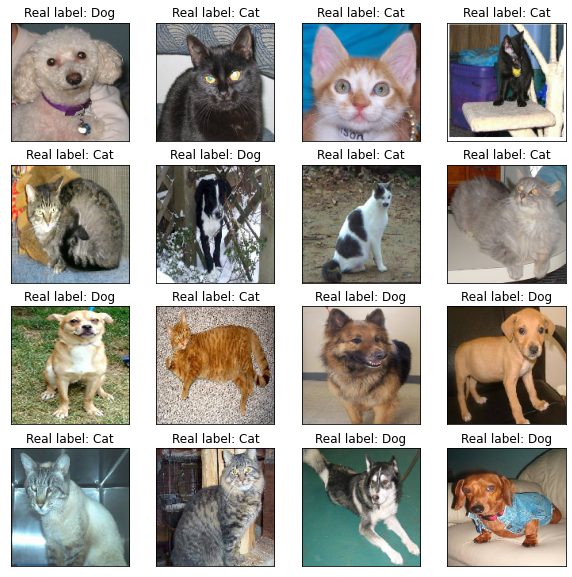

In [13]:
show_catsdogs(sample_training_images, sample_labels)

# Модель


In [14]:
#Создаем модель
model = tf.keras.Sequential()

#Добавляем свёрточный слой с размером свертки 3,3. После каждого слоя добавляем слой MaxPooling
model.add(tf.keras.layers.Conv2D(kernel_size=(3,3), filters=32, input_shape=(IMG_SHAPE, IMG_SHAPE, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

#Второй сверточный слой
model.add(tf.keras.layers.Conv2D(kernel_size=(3,3), filters=64, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

#Третий сверточный слой
model.add(tf.keras.layers.Conv2D(kernel_size=(3,3), filters=128, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

#Четвертый сверточный слой
model.add(tf.keras.layers.Conv2D(kernel_size=(3,3), filters=128, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

#Преобразуем тензор в вектор
model.add(tf.keras.layers.Flatten())

#Добавляем полносвязный слой нейронной сети
model.add(tf.keras.layers.Dense(128, activation='relu'))

#Выходной слой с активацией sigmoid
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [15]:
#Скомпилируем модель
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [16]:
#Структура модели
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 128)       1

In [ ]:
#Библиотека, которая реализует коллбек (кривые обучения в режиме реального времени)

!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

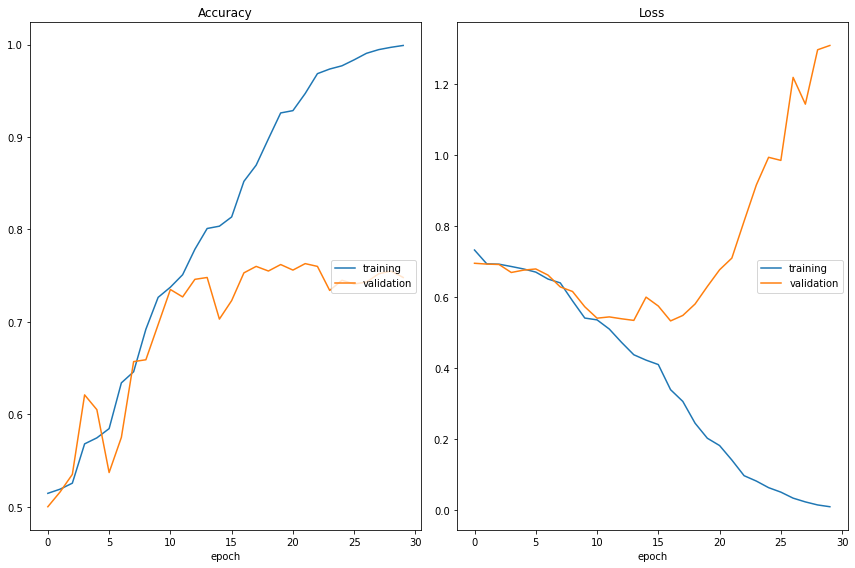

Accuracy
	training         	 (min:    0.515, max:    0.999, cur:    0.999)
	validation       	 (min:    0.500, max:    0.763, cur:    0.748)
Loss
	training         	 (min:    0.009, max:    0.732, cur:    0.009)
	validation       	 (min:    0.533, max:    1.309, cur:    1.309)
20/20 [==============================] - 8s 418ms/step - loss: 0.0086 - acc: 0.9990 - val_loss: 1.3093 - val_acc: 0.7480


In [18]:
#Обучим модель (возьмем 30 эпох для обучения)

EPOCHS = 30
history = model.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback()]) #коллбек для отрисовки прогресса

Предсказания сети:

Found 1000 images belonging to 2 classes.


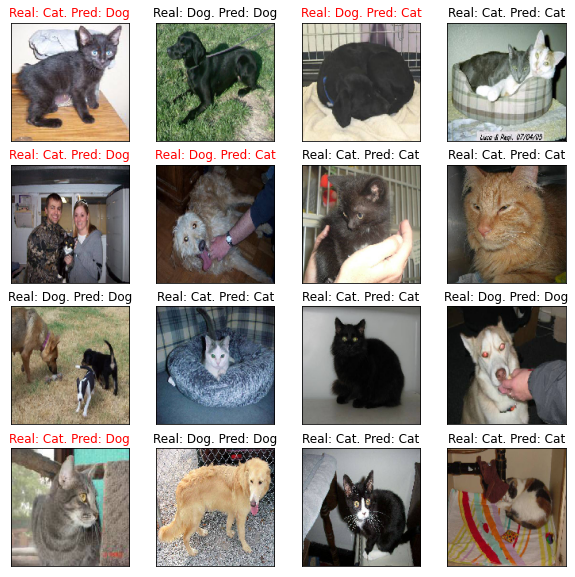

In [20]:
shuffle_val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=True,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                              class_mode='binary')
sample_validation_images, sample_validation_labels = next(shuffle_val_data_gen)
predicted = model.predict_classes(sample_validation_images).flatten()
show_catsdogs(sample_validation_images, sample_validation_labels, predicted)

# Recognize

Протестируем модель на своих данных

In [21]:
# Функция для изменения размера изображения
def resize(img, new_size):
    img = Image.fromarray(img)
    img = img.resize(new_size)
    return np.array(img)

#подготовка изображения (диапазон и размер)
def prepare_digit(img):
    img = resize(img, (IMG_SHAPE, IMG_SHAPE))
    img = img.astype(np.float32)/255

    img = np.reshape(img, (IMG_SHAPE, IMG_SHAPE, 3))
    return img

#Подготовка входных данных в н.с. (1, 150, 150, 3)
def prepare_input(img):
    img = np.array(img, dtype=np.uint8)
    ready_img = prepare_digit(img)
    return ready_img[None, ...]

In [26]:
#Загружаем необходимую для классификации картинку

img_fpath = '/content/cat.JPG'
img = Image.open(img_fpath)

In [27]:
#Подготовим картинку с помощью функций выше

test_img = prepare_input(img)

In [28]:
#Сделаем инференс

predicted = model.predict_classes(test_img).flatten()

In [31]:
#Результат
names = {0: "Cat", 1: "Dog"}



 It's a Cat ! 
 --------------- 



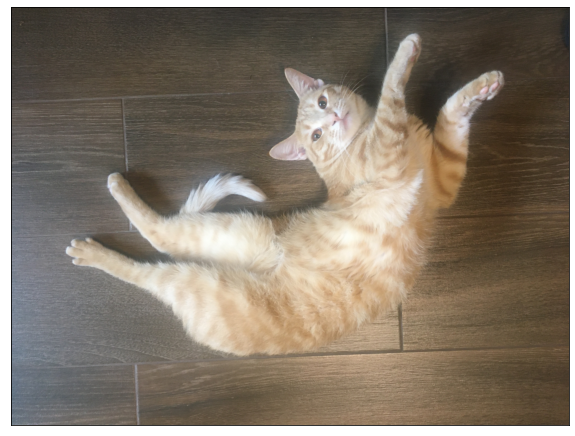

In [38]:
print('\n\n', f"It's a {names[predicted[0]]} !", '\n','-'*15, '\n')


plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(img, cmap=plt.cm.gray)